In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')
cwd = os.getcwd()
os.chdir('../')
os.getcwd()
from py_scripts.test_models_plot_roc_auc_curve import test_models_plot_roc_auc_curve

In [2]:
df_modif_1 = pd.read_csv('./data/manipulated_covid_data.csv') #Importa os dados

In [3]:
df_modif_1.isnull().sum() #Verifica os nulos

Unnamed: 0                  0
sex                         0
patient_type                0
intubed                     0
pneumonia                   0
age                         0
pregnancy                   0
diabetes                    0
copd                        0
asthma                      0
inmsupr                     0
hypertension                0
other_disease               0
cardiovascular              0
obesity                     0
renal_chronic               0
tobacco                     0
contact_other_covid    152277
covid_res                   0
icu                         0
age_cat                  1992
dtype: int64

In [4]:
X = df_modif_1.drop(['covid_res', 'Unnamed: 0','age_cat','contact_other_covid'], axis = 1) #Remove colunas não utilizadas e com muitos NANs não trataveis
y = df_modif_1['covid_res'] #Cria coluna alvo

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify = y)

In [6]:
rus = RandomUnderSampler(random_state=42) #Faz undersample devido a perda de poucos dados relacionados ao total
X_res2, y_res2 = rus.fit_resample(X, y)

In [7]:
sm = SMOTE(random_state=42) #Faz um SMOTE para comparação com Under
X_res, y_res = sm.fit_resample(X_train, y_train)


In [7]:
random_seed = 42

list_models = [
{'model_name': 'Decision Tree',
 'estimator' : DecisionTreeClassifier(random_state = random_seed)},
{'model_name': 'Random Forest',
 'estimator' : RandomForestClassifier(random_state = random_seed)}, 
{'model_name': 'AdaBoost',
 'estimator' : AdaBoostClassifier(random_state = random_seed)},
{'model_name': 'GradientBoosting',
 'estimator' : GradientBoostingClassifier(random_state = random_seed)},
{'model_name': 'XGBoost',
 'estimator' : XGBClassifier(random_state = random_seed)},
{'model_name': 'LightGBM',
 'estimator' : lgb.LGBMClassifier(random_state = random_seed)}
]

In [8]:
test_models_plot_roc_auc_curve(list_models, #Plota curva com SMOTE
                              "model_name",
                              "estimator",
                              X_res,
                              X_test,
                              y_res,
                              y_test)

NameError: name 'X_res' is not defined

In [10]:
clf_grad = GradientBoostingClassifier(random_state = 42, 
                                      n_estimators=500, verbose=2,
                                      max_depth=5, loss='exponential', 
                                      learning_rate=0.1)

clf_xgb = XGBClassifier(max_depth=7, 
                        eta=1, 
                        silent=1,
                        objective= 'binary:logistic',
                        eval_metric='auc',
                        learning_rate=0.05)

clf_lgb = lgb.LGBMClassifier(random_state = 42,
                             n_estimators=500, verbose=2,
                             max_depth=5, loss='exponential',
                             learning_rate=0.3,
                             boosting_type='dart')

In [18]:
clf_grad.fit(X_res, y_res)

eval_set = [(X_res, y_res), (X_test, y_test)]
eval_metric = ["auc","error"]
clf_xgb.fit(X_res, y_res, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

clf_lgb.fit(X_res, y_res)


      Iter       Train Loss   Remaining Time 
         1           0.9930            3.85m
         2           0.9872            3.87m
         3           0.9823            3.87m
         4           0.9783            3.88m
         5           0.9748            3.87m
         6           0.9719            3.91m
         7           0.9695            3.98m
         8           0.9675            4.01m
         9           0.9657            3.99m
        10           0.9642            4.00m
        11           0.9629            4.01m
        12           0.9619            4.02m
        13           0.9609            4.00m
        14           0.9601            4.00m
        15           0.9594            4.01m
        16           0.9587            3.99m
        17           0.9581            4.00m
        18           0.9576            3.98m
        19           0.9572            3.96m
        20           0.9568            3.94m
        21           0.9564            3.93m
        2

LGBMClassifier(boosting_type='dart', learning_rate=0.3, loss='exponential',
               max_depth=5, n_estimators=500, random_state=42, verbose=2)

In [12]:
y_grad_pred = clf_grad.predict(X_test)   #Verificação com os 3 melhore desempenhos
y_xgb_pred = clf_xgb.predict(X_test)
y_lgb_pred = clf_lgb.predict(X_test)
print(f'Gradient Boost')
print(classification_report(y_test, y_grad_pred))
print('-'*60)
print(f'XG Boost')
print(classification_report(y_test, y_xgb_pred))
print('-'*60)
print(f'LightG Boost')
print(classification_report(y_test, y_lgb_pred))

Gradient Boost
              precision    recall  f1-score   support

           0       0.64      0.78      0.70     55376
           1       0.61      0.43      0.51     43709

    accuracy                           0.63     99085
   macro avg       0.63      0.61      0.61     99085
weighted avg       0.63      0.63      0.62     99085

------------------------------------------------------------
XG Boost
              precision    recall  f1-score   support

           0       0.64      0.79      0.71     55376
           1       0.62      0.43      0.51     43709

    accuracy                           0.63     99085
   macro avg       0.63      0.61      0.61     99085
weighted avg       0.63      0.63      0.62     99085

------------------------------------------------------------
LightG Boost
              precision    recall  f1-score   support

           0       0.64      0.79      0.71     55376
           1       0.62      0.43      0.51     43709

    accuracy           

Model      : Decision Tree
Accuracy   : 0.6368 
Precision  : 0.6338 
Recall     : 0.6368 
F1 - Score : 0.6267 
ROC - AUC  : 0.6181 
Model      : Random Forest
Accuracy   : 0.6363 
Precision  : 0.6329 
Recall     : 0.6363 
F1 - Score : 0.6278 
ROC - AUC  : 0.6191 
Model      : AdaBoost
Accuracy   : 0.6214 
Precision  : 0.6171 
Recall     : 0.6214 
F1 - Score : 0.6155 
ROC - AUC  : 0.6068 
Model      : GradientBoosting
Accuracy   : 0.6268 
Precision  : 0.6227 
Recall     : 0.6268 
F1 - Score : 0.6184 
ROC - AUC  : 0.6097 
[17:52:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model      : XGBoost
Accuracy   : 0.6323 
Precision  : 0.6291 
Recall     : 0.6323 
F1 - Score : 0.6214 
ROC - AUC  : 0.6130 
Model      : LightGBM
Accuracy   : 0.6

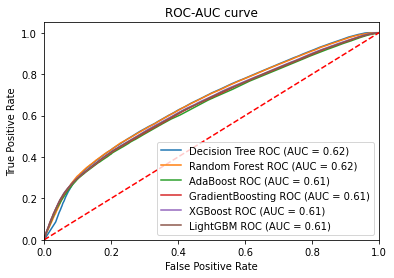

In [9]:
test_models_plot_roc_auc_curve(list_models, #Teste com under sample
                              "model_name",
                              "estimator",
                              X_res2,
                              X_test,
                              y_res2,
                              y_test)

In [10]:
clf_dec_tree = DecisionTreeClassifier(random_state = 42) #Teste com os três melhores desempenhos

clf_xgb2 = XGBClassifier (random_state=42,
                            n_estimators=250,
                            max_depth=7, 
                            eta=1, 
                            silent=1,
                            objective= 'binary:logistic',
                            eval_metric='auc',
                            learning_rate=0.05)

clf_rand_cl = RandomForestClassifier(random_state = 42,
                                        n_estimators=100)

In [11]:
clf_dec_tree.fit(X_res2, y_res2)

eval_set = [(X_res2, y_res2), (X_test, y_test)]
eval_metric = ["auc","error"]
clf_xgb2.fit(X_res2, y_res2, eval_metric=eval_metric, eval_set=eval_set, verbose=True)


clf_rand_cl.fit(X_res2, y_res2)


[17:53:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.64726	validation_0-error:0.39120	validation_1-auc:0.64653	validation_1-error:0.37005
[1]	validation_0-auc:0.64788	validation_0-error:0.39067	validation_1-auc:0.64686	validation_1-error:0.37020
[2]	validation_0-auc:0.64805	validation_0-error:0.39060	validation_1-auc:0.64730	validation_1-error:0.37010
[3]	validation_0-auc:0.64865	validation_0-error:0.39059	validation_1-auc:0.64784	validation_1-error:0.37005
[4]	validation_0-auc:0.64861	validation_0-error:0.39072	validation_1-auc:0.64787	validation_1-error:0.36956
[5]	validation_0-auc:0.64927	validation_0-err

RandomForestClassifier(random_state=42)

In [13]:
y_dec_pred = clf_dec_tree.predict(X_test) #Verificação dos melhores desempenhos
y_xgb_pred2 = clf_xgb2.predict(X_test)
y_rand_cl = clf_rand_cl.predict(X_test)
print(f'Decision Tree')
print(classification_report(y_test, y_dec_pred))
print('-'*60)
print(f'XG Boost')
print(classification_report(y_test, y_xgb_pred2))
print('-'*60)
print(f'Random Forest')
print(classification_report(y_test, y_rand_cl))

Decision Tree
              precision    recall  f1-score   support

           0       0.65      0.78      0.71     55376
           1       0.62      0.46      0.53     43709

    accuracy                           0.64     99085
   macro avg       0.63      0.62      0.62     99085
weighted avg       0.63      0.64      0.63     99085

------------------------------------------------------------
XG Boost
              precision    recall  f1-score   support

           0       0.64      0.78      0.70     55376
           1       0.61      0.45      0.52     43709

    accuracy                           0.63     99085
   macro avg       0.63      0.61      0.61     99085
weighted avg       0.63      0.63      0.62     99085

------------------------------------------------------------
Random Forest
              precision    recall  f1-score   support

           0       0.65      0.77      0.70     55376
           1       0.61      0.47      0.53     43709

    accuracy           

In [20]:
# Number of trees in random forest 
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 4)] #Dados do RandomSearch

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 40, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2 ,3 ,4]

# Create the random grid
params_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

pprint(params_grid)

{'max_depth': [2, 11, 21, 30, 40, None],
 'min_samples_leaf': [1, 2, 3, 4],
 'min_samples_split': [2, 3, 4, 5, 10],
 'n_estimators': [200, 466, 733, 1000]}


In [22]:
from sklearn.model_selection import RandomizedSearchCV

In [24]:
random_search = RandomizedSearchCV(estimator = clf_rand_cl, 
                                   param_distributions = params_grid, 
                                   n_iter = 10, 
                                   cv = 3, 
                                   verbose=2,
                                   n_jobs = -1)

#Chamada do RandomSearch


In [25]:
%%time

random_search.fit(X_res2, y_res2)
#Teste com o Random Search ///// DEMORA MUITO TEMPO E NÃO TEM BONS RESULTADOS

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Wall time: 19min 11s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 11, 21, 30, 40, None],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5, 10],
                                        'n_estimators': [200, 466, 733, 1000]},
                   verbose=2)

In [26]:
print(random_search.cv_results_['mean_test_score'].mean())

0.603900183489597


In [27]:
random_search.best_params_

{'n_estimators': 733,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': 11}

In [28]:
clf_deci = RandomForestClassifier(random_state = 42,  #Verificando os valores do RandomSearch
                                     max_depth=11,
                                     min_samples_split=5,
                                     min_samples_leaf=2,
                                     n_estimators =733
                                 )

In [29]:
clf_deci.fit(X_res2, y_res2)

RandomForestClassifier(max_depth=11, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=733, random_state=42)

In [30]:
y_pred_deci = clf_deci.predict(X_test)

In [31]:
print(f'Arvore de decisão')
print(classification_report(y_test, y_pred_deci))

Arvore de decisão
              precision    recall  f1-score   support

           0       0.64      0.78      0.70     55376
           1       0.62      0.44      0.52     43709

    accuracy                           0.63     99085
   macro avg       0.63      0.61      0.61     99085
weighted avg       0.63      0.63      0.62     99085



In [ ]:
ovo = OneVsOneClassifier(clf_rand_cl) #Teste com OVO e OVR ////// Com apenas dois valores não faz diferença, depois de perceber, deixei pelo aprendizado
ovr = OneVsRestClassifier(clf_rand_cl)

In [ ]:
ovo.fit(X_res2, y_res2)
ovr.fit(X_res2, y_res2)

OneVsRestClassifier(estimator=RandomForestClassifier(random_state=42))

In [ ]:
y_ovo = ovo.predict(X_test)
y_ovr = ovr.predict(X_test)

In [ ]:
print(f'OvO Random Forest')
print(classification_report(y_test, y_ovo))
print('-'*60)
print(f'OvR Random Forest')
print(classification_report(y_test, y_ovr))
print('-'*60)

In [ ]:
#Não ouve melhora na utilização do RandomSeach, e a base de dados grande torna o calculo muito demorado.
#Melhor desempenho foi do clf_rand_cl onde o mesmo possui melhor valor para para classifcação de 1

#Random Forest
#              precision    recall  f1-score   support

#           0       0.65      0.77      0.70     55376
#           1       0.61      0.47      0.53     43709

#    accuracy                           0.64     99085
#   macro avg       0.63      0.62      0.62     99085
#weighted avg       0.63      0.64      0.63     99085

In [2]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_rand_cl)

plot_confusion_matrix(conf_mat=cm)
plt.show()

NameError: name 'y_test' is not defined